# tmp-overfitting-example-noise-polynomial

Fit Gaussian noise with polynomial with high degree to force it to overfit.

---
tags: pytorch, exploration, overfitting, polynomial regression, curve fitting

# Imports

In [13]:
from tqdm import tqdm

import numpy as np
import torch
from torch.nn import Module, Sequential, Linear, MSELoss
from torch.optim import SGD

import matplotlib.pyplot as plt
%matplotlib inline

# Custom class

In [2]:
class Powers(Module):
    def __init__(self, d):
        r"""Argument `d` is degree of polynomial."""
        super(Powers, self).__init__()
        self.d = d
        
    def forward(self, x):
        r"""Returns (positive) powers of input tensor."""
        return torch.cat([x**i for i in range(1, self.d+1)], 1)
   

# Standard scheme

100%|██████████| 100/100 [00:00<00:00, 1605.47it/s]


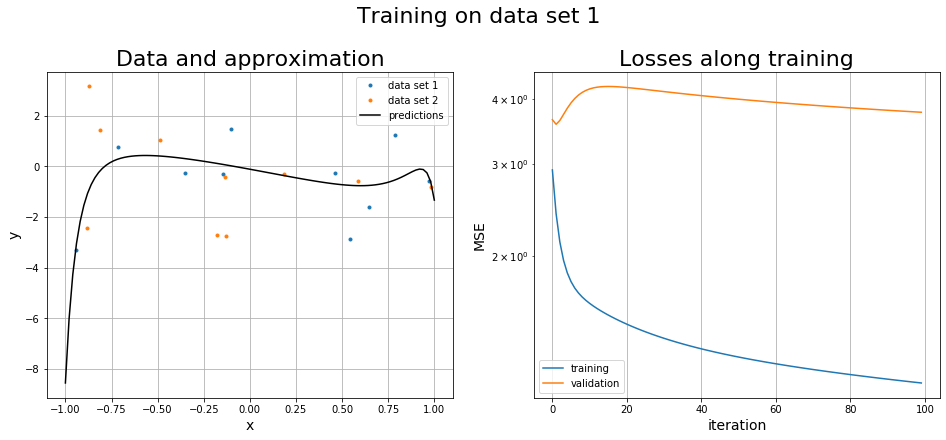

In [14]:
torch.manual_seed(12346) # for reproducibility

# Parameters: data and setup
d = 40 # degree of polynomial approximating data
lr = .1
n_epochs = 100
n = 20 # nb samples
std = 2. # samples are Gaussian with zero mean

# Data
x1 = -1. + 2.*torch.rand(n//2, 1)
y1 = std*torch.randn(n//2, 1)

x2 = -1. + 2.*torch.rand(n-n//2, 1)
y2 = std*torch.randn(n-n//2, 1)
# plt.plot(x1, y1, 'o', label='1')
# plt.plot(x2, y2, 'o', label='2');

# Training setup
model = Sequential(Powers(d), Linear(d,1))

criterion = MSELoss(reduction='mean')
optimizer = SGD(model.parameters(), lr=lr)


losses = {}
losses['training'] = []
losses['validation'] = []

# Training
for _ in tqdm(range(n_epochs)):
    with torch.no_grad():
        preds_v = model(x2)
        loss_v = criterion(preds_v, y2)
    losses['validation'].append(loss_v.data.item())
    optimizer.zero_grad()
    preds = model(x1)
    loss = criterion(preds, y1)    
    losses['training'].append(loss.data.item())
    loss.backward()

    optimizer.step()
    
    
# Intermediate regressors
inputs = torch.linspace(-1., 1., 101).view(-1, 1)
with torch.no_grad():
    outputs = model(inputs)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

ax = axs[0]
ax.plot(x1, y1, '.', label='data set 1')
ax.plot(x2, y2, '.', label='data set 2');
ax.plot(inputs, outputs, 'k', label='predictions')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)    
ax.set_title("Data and approximation", fontsize=22)
ax.legend();
ax.grid();

ax = axs[1]
ax.plot(losses['training'], label='training')
ax.plot(losses['validation'], label='validation')
ax.set_xlabel("iteration", fontsize=14)
ax.set_ylabel("MSE", fontsize=14)
ax.set_title("Losses along training", fontsize=22)
ax.legend()
ax.grid()
ax.set_yscale('log');

fig.suptitle("Training on data set 1", fontsize=22, y=1.03);

# Reshuffling scheme

100%|██████████| 100/100 [00:00<00:00, 1434.70it/s]


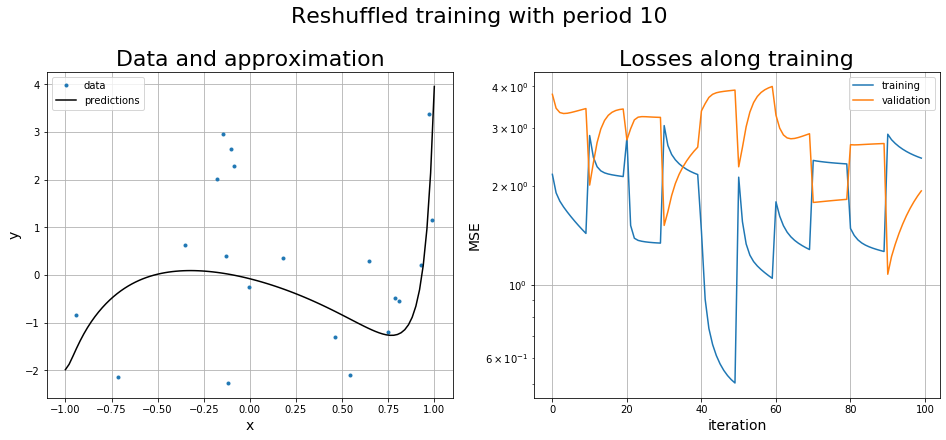

In [18]:
torch.manual_seed(12346) # for reproducibility

# Parameters: data and setup
n = 20 # nb samples
std = 2. # samples are Gaussian with zero mean
d = 40 # degree of polynomial approximating data

lr = .1

period = 10
n_periods = 10
n_epochs = n_periods*period

# Data
xx = -1. + 2.*torch.rand(n, 1)
yy = std*torch.randn(n, 1)

# Training setup
model = Sequential(Powers(d), Linear(d,1))

criterion = MSELoss(reduction='mean')
optimizer = SGD(model.parameters(), lr=lr)


losses = {}
losses['training'] = []
losses['validation'] = []

# Training
for i in tqdm(range(n_epochs)):
    if i % period == 0:
        rows = np.random.permutation(range(n))
        n_split = len(rows)//2
        rowst, rowsv = rows[:n_split], rows[n_split:]

    xt, xv = xx[rowst,:], xx[rowsv,:]
    yt, yv = yy[rowst,:], yy[rowsv,:]

    with torch.no_grad():
        preds_v = model(xv)
        loss_v = criterion(preds_v, yv)
    losses['validation'].append(loss_v.data.item())
    optimizer.zero_grad()
    preds = model(xt)
    loss = criterion(preds, yt)    
    losses['training'].append(loss.data.item())
    loss.backward()

    optimizer.step()
    
    
# Intermediate regressors
inputs = torch.linspace(-1., 1., 101).view(-1, 1)
with torch.no_grad():
    outputs = model(inputs)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

ax = axs[0]
ax.plot(xx, yy, '.', label='data')
ax.plot(inputs, outputs, 'k', label='predictions')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)    
ax.set_title("Data and approximation", fontsize=22)
ax.legend();
ax.grid();

ax = axs[1]
ax.plot(losses['training'], label='training')
ax.plot(losses['validation'], label='validation')
ax.set_xlabel("iteration", fontsize=14)
ax.set_ylabel("MSE", fontsize=14)
ax.set_title("Losses along training", fontsize=22)
ax.legend()
ax.grid()
ax.set_yscale('log');

fig.suptitle(f"Reshuffled training with period {period}", fontsize=22, y=1.03);